# Notebook motivation 
In this notebook we will check the data that we have save in raw and processed folder


In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# first impoort the paths from the config file
from config import settings
from pathlib import Path

settings_type = 'SETTINGS1'
data_path = Path(settings.data['path']['raw'])
settings_config = settings.simulation[settings_type]
data_base_path = (data_path/settings_type/settings_type.lower()).with_suffix('.db')

# Latent variables checking

In [3]:
# now let's load the table systems from the sqlite database
import sqlite3
conn = sqlite3.connect(data_base_path)
c = conn.cursor()
c.execute("""SELECT latent FROM systems""")
latent = c.fetchall()
latent = np.array([l[0] for l in latent])
conn.close()

In [4]:
settings_config

<Box: {'simu_params': {'dt': 0.0025, 't_end': 20}, 'env_exc_params': {'lat_std': 20, 'lat_mu': 60, 'exc_location': 7, 'exc_amp': 5, 'exc_loc': 10, 'exc_shape': 1.9}, 'population_param': '/home/yacine/Documents/PhD/Code/GitProject/PBSHM_mdof/configuration/systems_healthy.json', 'anomaly_loc': 5}>

In [91]:
# compute the number of samples 


8000.0

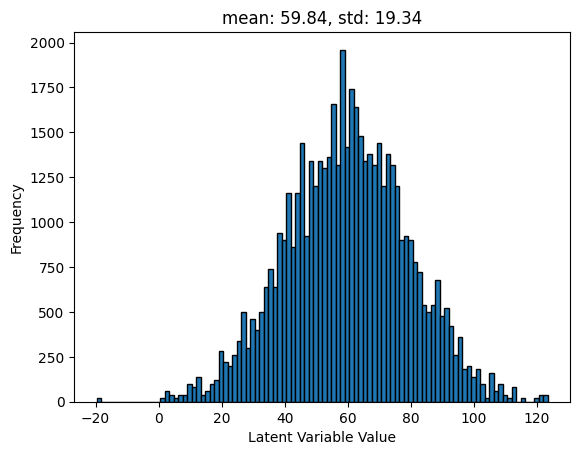

except mean and std: 60.00, 20.00
actual mean and std: 59.84, 19.34


In [5]:
plt.hist(latent, bins=100, edgecolor='black')
plt.title(f'mean: {np.mean(latent):.2f}, std: {np.std(latent):.2f}')
plt.xlabel('Latent Variable Value')
plt.ylabel('Frequency')
plt.show()
print(f'except mean and std: {settings_config["env_exc_params"]["lat_mu"]:.2f}, {settings_config["env_exc_params"]["lat_std"]:.2f}')
print(f'actual mean and std: {np.mean(latent):.2f}, {np.std(latent):.2f}')


# Excitation checking

In [6]:
# now let's load the table systems from the sqlite database
import sqlite3
conn = sqlite3.connect(data_base_path)
c = conn.cursor()
c.execute("""SELECT amplitude FROM systems""")
amplitude = c.fetchall()
amplitude = np.array([l[0] for l in amplitude])
conn.close()

Text(0, 0.5, 'Frequency')

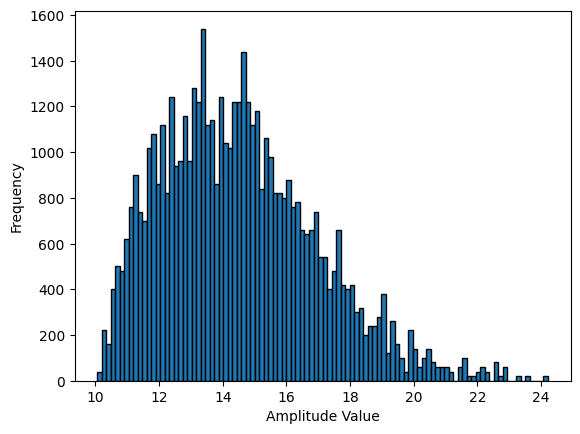

In [7]:
plt.hist(amplitude, bins=100, edgecolor='black')
plt.xlabel('Amplitude Value')
plt.ylabel('Frequency')


In [9]:
# amplitude is a weibull distribution lets check the parameters
from scipy.stats import weibull_min
shape, loc, scale = weibull_min.fit(amplitude)
print(f'except shape, loc, scale: {settings_config["env_exc_params"]["exc_shape"]:.2f}, {settings_config["env_exc_params"]["exc_loc"]:.2f}, {settings_config["env_exc_params"]["exc_amp"]:.2f}')
print(f'actual shape, loc, scale: {shape:.2f}, {loc:.2f}, {scale:.2f}')

except shape, loc, scale: 1.90, 10.00, 5.00
actual shape, loc, scale: 1.93, 10.02, 5.06


# Checking anomaly level

In [10]:
import sqlite3
conn = sqlite3.connect(data_base_path)
c = conn.cursor()
c.execute("""SELECT anomaly_level FROM simulation""")
anomaly_level = c.fetchall()
anomaly_level = np.array([l[0] for l in anomaly_level])
conn.close()

In [11]:
# count the number of anomalies per level
from collections import Counter
print(Counter(anomaly_level))
print("don't forget that we have 20 individuals so we have to divide by 20")





Counter({0.0: 24000, 0.01: 4000, 0.03: 4000, 0.05: 4000, 0.07: 4000, 0.09: 4000, 0.11: 4000, 0.13: 4000})
don't forget that we have 20 individuals so we have to divide by 20


# Checking resonance frequency 

In [58]:
import numpy as np
import sqlite3

conn = sqlite3.connect(data_base_path)
c = conn.cursor()
c.execute("""
SELECT resonance_frequency, name, anomaly_level 
FROM simulation""")
data = c.fetchall()
resonance_frequencies = np.array([np.frombuffer(r[0]) for r in data])
system_name = np.array([r[1] for r in data])
anomaly_level = np.array([r[2] for r in data])
conn.close()

In [59]:
conn = sqlite3.connect(data_base_path)
c = conn.cursor()

c.execute("""SELECT latent FROM systems""")
latent = c.fetchall()
latent = np.array([l[0] for l in latent])
conn.close()


## anomaly effect


In [89]:
import matplotlib.cm as cm
def plot_system_data(system_name_input):
    # Select the system based on input name
    selected_system = system_name == system_name_input
    resonance_frequencies_system = resonance_frequencies[selected_system]
    anomaly_level_system = anomaly_level[selected_system]
    latent_system = latent[selected_system]
    # Check the index of switching levels 
    switching_index = np.where(np.diff(anomaly_level_system))[0] + 2
    switching_level = anomaly_level_system[switching_index]
    dict_anomaly = {switching_index[i]:switching_level[i] for i in range(len(switching_index))}


    fig, ax = plt.subplots(figsize=(20,10), ncols=2, nrows=4)
    for i in range(8):
        ax_temp = ax[i//2, i%2]
        scatter = ax_temp.scatter(range(len(resonance_frequencies_system[:, i])), 
                                  resonance_frequencies_system[:, i], 
                                  c=latent_system, cmap=cm.GnBu,
                                  marker='o', s=2)
        bound_y = ax_temp.get_ylim()
        range_y = bound_y[1] - bound_y[0]
        three_quarter_y = bound_y[0] + range_y * 3 / 4
        one_quarter_y = bound_y[0] + range_y / 4
        for k, v in dict_anomaly.items():
            ax_temp.axvline(k, color='red', linestyle='--')
            ax_temp.text(k - 100, three_quarter_y, f'{v}', rotation=90, fontsize=12, zorder=2)
        ax_temp.text(200, one_quarter_y, f'freq {8-i}', fontsize=14, zorder=2)

    # Create colorbar
    cbar = plt.colorbar(cm.ScalarMappable(cmap=cm.GnBu, 
                                          norm=plt.Normalize(vmin=np.min(latent_system), vmax=np.max(latent_system))), 
                        ax=ax.ravel().tolist())
    cbar.set_label('Latent System Value')

    plt.show()


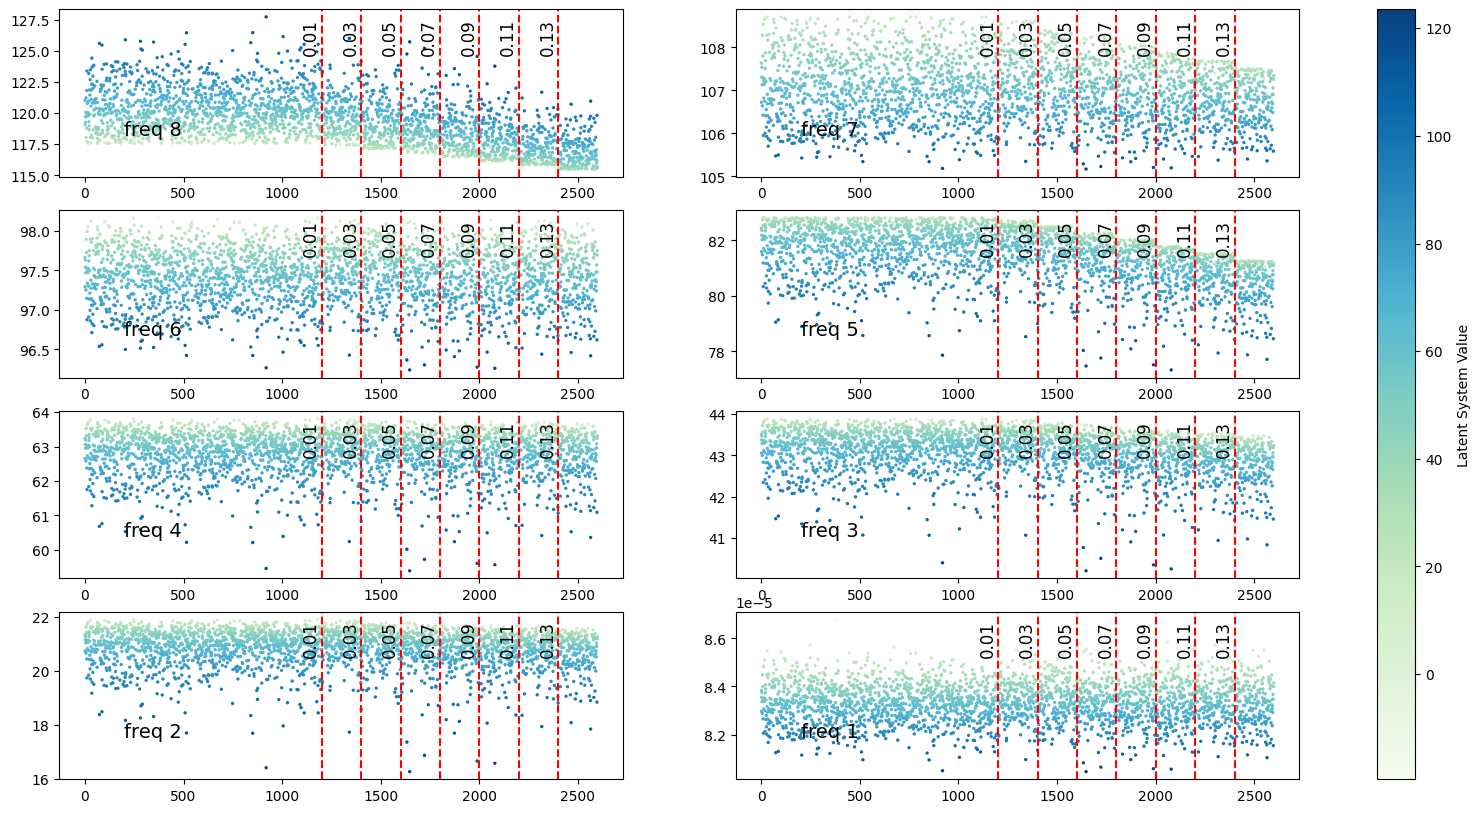

In [90]:
plot_system_data('system_1')

## population difference 


In [92]:
# here we group the data by system name for anomaly level 0 and we check the difference in means
import pandas as pd
res_freq_col = [f'res_freq_{i}' for i in range(8)]
data = {res_freq_col[i]:resonance_frequencies[:, i] for i in range(8)}
rest_data = {'name':system_name, 'anomaly_level':anomaly_level, 'latent':latent}
data.update(rest_data)
df = pd.DataFrame(data)
df_anomaly_0 = df[df['anomaly_level']==0]
df_res = df_anomaly_0.groupby('name').mean().iloc[:,:8]
df_res

,res_freq_0,res_freq_1,res_freq_2,res_freq_3,res_freq_4,res_freq_5,res_freq_6,res_freq_7
name,,,,,,,,
system_0,125.106033,104.928069,99.632547,80.948766,61.885398,44.070341,21.394146,0.000084
system_1,120.435844,107.089530,97.418653,81.773607,62.788381,43.152973,20.863273,0.000083
system_10,123.674023,110.694822,101.434149,83.426051,64.435880,44.617704,21.621153,0.000086
system_11,123.764195,108.735471,103.368530,81.869039,65.326201,44.792651,22.188629,0.000086
system_12,122.236824,105.843433,99.379656,83.211381,63.639489,44.216897,21.518862,0.000085
system_13,120.908261,106.790422,97.451095,80.438796,62.977376,43.643584,21.499576,0.000084
system_14,128.833958,110.506735,101.510388,82.553646,64.925729,44.632949,21.683008,0.000086
system_15,123.640119,112.792625,101.236151,82.166505,65.303200,44.027713,21.865400,0.000086
system_16,126.183579,107.302506,99.192748,79.749811,65.215458,43.305914,21.596488,0.000085


In [86]:
import scipy.stats as stats
cv = stats.variation(df_res)
cv

array([0.02044207, 0.02029862, 0.01801251, 0.01407016, 0.01885243,
       0.01580315, 0.01292565, 0.00967964])